# Feature Independency

Author claims that some responses of convolutions consist of locally independent features. <br> 
Then each features can generate the object on the similar positions in the image independently. <br>

In this experiment, we will generate the image patches from the feature patches of specific layer. <br>
If each patches generate the objects on similar positions in image, the patches are less dependent between neighbors. <br>

## Prepare

Load model and checkpoints.

In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
from utils import nethook
from utils.seqstylegan2 import SeqStyleGAN2

In [3]:
device = torch.device('cuda')

In [4]:
# Load sequential stylegan2
stylegan = SeqStyleGAN2(
    size=256, style_dim=512, n_mlp=8, truncation=1, mconv='seq')
stylegan.to(device)
_ = stylegan.requires_grad_(False)

In [5]:
# Load checkpoint
ckpt = torch.load('./release/stylegan2-church-config-f.pt')
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [6]:
# sample latent
latent = torch.randn(1, 512, device=device)

In [7]:
sample = stylegan(latent.clone())
sample.shape

torch.Size([1, 3, 256, 256])

In [8]:
def postproc(sample):
    """Postprocessor, min-max normalization, BHWC permutation.
    Args:
        sample: torch.Tensor, [B, C, H, W], generated image.
    Returns:
        np.ndarray, [B, H, W, C], normalized image in range [0, 1].
    """
    sample = sample.permute(0, 2, 3, 1).cpu().detach().numpy()
    min_ = sample.min(axis=(1, 2, 3), keepdims=True)
    max_ = sample.max(axis=(1, 2, 3), keepdims=True)
    sample = (sample - min_) / (max_ - min_)
    return sample

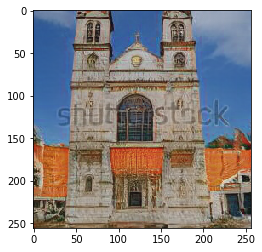

In [9]:
plt.imshow(postproc(sample)[0])

In [10]:
# target feature map
target_layer = 8

# layer name
target_first = 'layer{}.sconv.mconv.dconv'.format(target_layer)
target_last = 'layer{}.sconv.activate'.format(target_layer)

# split
context_model = nethook.subsequence(
    stylegan,
    upto_layer=target_first,
    share_weights=True)
target_model = nethook.subsequence(
    stylegan,
    first_layer=target_first,
    last_layer=target_last,
    share_weights=True)
render_model = nethook.subsequence(
    stylegan,
    after_layer=target_last,
    share_weights=True)

## Generate patched image

Generate feature map patches and inference isolately.

In [11]:
with torch.no_grad():
    # generate feature map
    context = context_model(latent.clone())
    size = context.output.size(-1)

In [12]:
def make_patch(tensor, unit):
    """Make feature map as batched patches.
    Args:
        tensor: torch.Tensor, [B, C, H, W], input feature map.
        unit: int, patch size.
    Returns:
        torch.Tensor, [B', C, unit, unit], patches.
            where B' = B x (H // unit) x (W // unit).
    """
    # B, C, H, W
    b, c, h, w = tensor.size()
    # [B, C, H // U, U, W // U, U]
    tensor = tensor.view(b, c, h // unit, unit, w // unit, unit)
    # [B, H // U, W // U, C, U, U]
    tensor = tensor.permute(0, 2, 4, 1, 3, 5)
    # [B', C, U, U]
    return tensor.reshape(-1, c, unit, unit)

In [13]:
unit = 2
context.output = make_patch(context.output, unit)
context.fmap = make_patch(context.fmap, unit)

bsize = context.output.size(0)
context.style = context.style.repeat(bsize, 1)
context.latent = context.latent.repeat(bsize, 1, 1)

In [14]:
with torch.no_grad():
    # generate patched images
    target = render_model(target_model(context))

In [15]:
# # for preventing error of insufficient gpu memory
# with torch.no_grad():
#     output = context.output
#     fmap = context.fmap
#     style = context.style
#     latent = context.latent

#     subbatch = 64

#     target = []
#     for i in range(bsize // subbatch):
#         context.output = output[i * subbatch:(i + 1) * subbatch]
#         context.fmap = fmap[i * subbatch:(i + 1) * subbatch]
#         context.style = style[i * subbatch:(i + 1) * subbatch]
#         context.latent = latent[i * subbatch:(i + 1) * subbatch]

#         target.append(render_model(target_model(context)))

#     target = torch.cat(target)

In [16]:
def recover_patch(tensor, factor):
    """Recover patches to original image.
    Args:
        tensor: torch.Tensor, [B, C, H, W], generated images.
        factor: int, upsample factor.
    Returns
        torch.Tensor, [B / factor^2, C, HxF, WxF], recovered image.
    """
    # [B', C, H', W']
    b, c, h, w = tensor.size()
    # [B, H // U, W // U, C, H', W']
    tensor = tensor.view(-1, factor, factor, c, h, w)
    # [B, C, H // U, H', W // U, W']
    tensor = tensor.permute(0, 3, 1, 4, 2, 5)
    # [B, C, H // U x H', W // U x W']
    return tensor.reshape(-1, c, factor * h, factor * w)

In [17]:
# recover image
total = recover_patch(target, size // unit)
total.shape

torch.Size([1, 3, 256, 256])

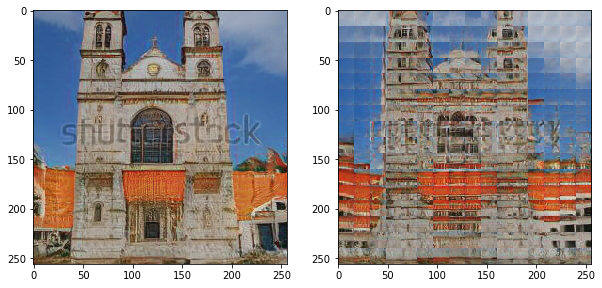

In [18]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(postproc(sample)[0])
plt.subplot(1, 2, 2)
plt.imshow(postproc(total)[0])

## Results

The generated image has similar contexts of an original image. <br>
But it is less natural, since it does not have the neighbors information. <br>

However, we can assume that each features in specific feature map encode the raw objects. <br>
Because generated patches represent similar contexts of originals, like colors, objects, positions, etc. <br>